### КАКОЙ КЕЙС РЕШАЕМ?
Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.
### Содержание
1. Загрузка данных и первичное исследование;
2. Очистка данных:

    1) Очистка от дубликатов;
    
    2) Очистка от пропусков.
3. Создание новых признаков;
4. Кодирование признаков;
5. Нормализация чисовых признаков;
6. Отбор признаков;
7. Обучение модели и получение предсказания.

In [485]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Импортируем библиотеки для работы с отзывами
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# Загружаем специальный инструмент для геоаналитики:
from geopy.geocoders import Nominatim

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [486]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [487]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## 1. Загрузка данных и первичное исследование

In [488]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [489]:
# Смотрим тренировончные данные
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [490]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [491]:
# Смотрим тестовые данные
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [492]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [493]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [494]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [495]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [496]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [497]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lng'}>,
        <AxesSubplot:title={'center':'sample'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

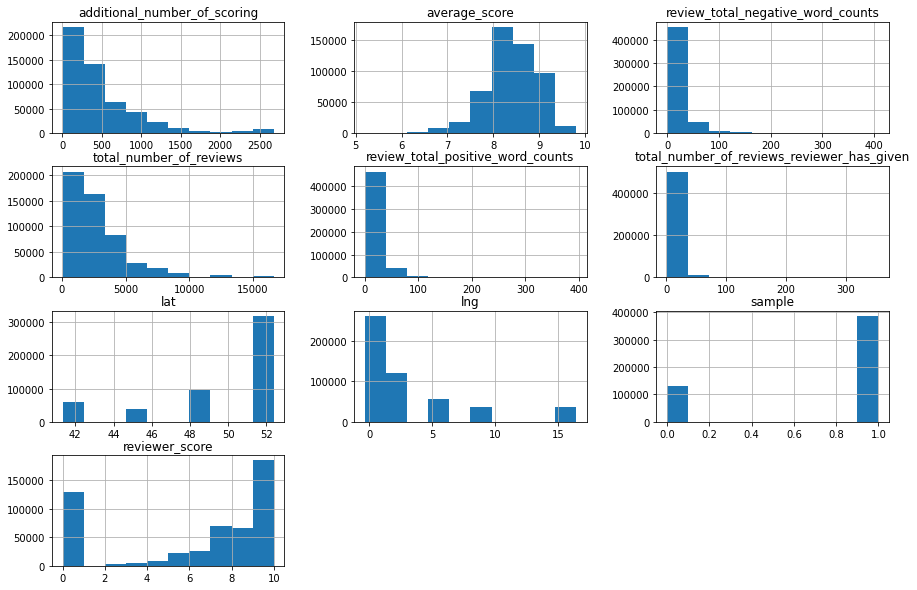

In [498]:
data.hist(figsize=(15,10))

## 2. Очистка данных

### 1. Очистка от дубликатов

In [499]:
# Проверим тренеровочные данные на наличие полных дубликатов:
print('Количество дубликатов: {}'.format(df_train[df_train.duplicated()].shape[0]))

# Удаляем дубликаты:
df_train = df_train.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(df_train.shape))

Количество дубликатов: 307
Размер таблицы после удаления дубликатов: (386496, 18)


In [500]:
# Cнова объединяем
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

data = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [501]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

### 2. Очистка данных от пропусков

В наборе данных имееются всего два признака с пропусками - lat и lng. Избавимся от пропусков в данных признаках.

In [502]:
# Заменим пропуски в признаках lat и lng на 0
data[['lat','lng']] = data[['lat','lng']].fillna(0)

In [503]:
# Создадим датасет из строк с значениями lat и lng = 0
mask = ((data['lat'] == 0) | (data['lng'] == 0))
hotel_nun_coord = data[mask] 

In [504]:
# Создадим списки: с названиями отелей и их адресами
hotels_name = hotel_nun_coord['hotel_name'].value_counts().index.to_list()
hotels_address = hotel_nun_coord['hotel_address'].value_counts().index.to_list()

list(zip(hotels_name, hotels_address))[:6]

# Следующий код следует выполнить на локальной машине, чтобы выполнился быстрее, нежели kaggle
# Поэтому ниже инициализирем сразу словарь с названием отеля и его координатами

# geolocator = Nominatim(user_agent="SF_DS")
# coord_dict = {}
# for name, address in zip(hotels_name, hotels_address):    
#     address = address.split(' ')[-4:]
#     adsress = address[0] + ' ' +address[1] + ' ' + address[2] + ' ' + address[3]  
#     place = geolocator.geocode(address, exactly_one=True, language='en')
#     if name not in coord_dict:
#         coord_dict[name] = (place.latitude, place.longitude)
# print(coord_dict)

# Получим словарь с названиями отелей и их координатами
coord_dict = {
    'Fleming s Selection Hotel Wien City': (48.2108519, 16.347359861911986), 
    'Hotel City Central': (48.2006384, 16.426895311477978), 
    'Hotel Atlanta': (48.22507295, 16.35839764159848), 
    'Maison Albar Hotel Paris Op ra Diamond': (48.8870221, 2.3478318), 
    'Hotel Daniel Vienna': (48.20254735, 16.38461641187194), 
    'Hotel Pension Baron am Schottentor': (48.22507295, 16.35839764159848), 
    'Austria Trend Hotel Schloss Wilhelminenberg Wien': (48.2149546, 16.302153494876826), 
    'NH Collection Barcelona Podium': (41.3936885, 2.1636552), 
    'Derag Livinghotel Kaiser Franz Joseph Vienna': (48.2048346, 16.3702081), 
    'City Hotel Deutschmeister': (48.22507295, 16.35839764159848), 
    'Holiday Inn Paris Montmartre': (48.8870221, 2.3478318), 
    'Hotel Park Villa': (48.2048346, 16.3702081), 
    'Cordial Theaterhotel Wien': (48.2108519, 16.347359861911986), 
    'Roomz Vienna': (48.16310865, 16.458012842051907), 
    'Mercure Paris Gare Montparnasse': (48.8870221, 2.3478318), 
    'Hotel Advance': (41.3936885, 2.1636552), 
    'Renaissance Barcelona Hotel': (41.3936885, 2.1636552)
}

# Cоздадим функцию для замены нулевых значений на координаты из словаря
def fill_coords(row):
    if row.lat == 0:
        coord = coord_dict[row.hotel_name]
        row.lat = coord[0]
        row.lng = coord[1]
        return row
    else:
        return row
    
# Применим функцию    
data = data.apply(lambda row: fill_coords(row), axis=1)

# Проверим наличие пропусков
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
dtype: int64

## 3. Создание новых признаков

### Страна, в котором находится отель

In [505]:
# Создадим функию для получения признака "старана отеля"

def get_country(address):
    """Функция получает на вход адрес отеля и возвращает название страны, указанной в адресе.

    Args:
        str: Входные данные в формате строки

    Returns:
        str: Возвращает данные в формате строки
    """
    address = address.split(' ')
    country = address[-1]
    # В датасете есть одна страна, название которой состоит из двух слов, поэтому зададим условие
    if country == 'Kingdom':
        return 'United Kingdom'
    else:
        return country

In [506]:
# Создание признака "страна отеля"
data['hotel_country'] = data['hotel_address'].apply(get_country)

# В каких странах, расположены отели из датасета
data['hotel_country'].value_counts()

United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: hotel_country, dtype: int64

Text(0.5, 1.0, 'Средняя оценка по странам')

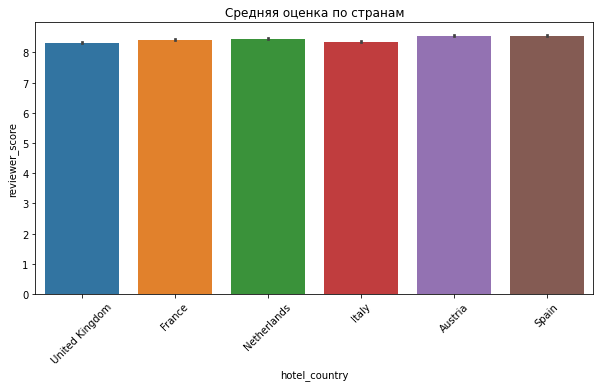

In [507]:
# Средняя оценка по странам
plt.rcParams['figure.figsize'] = (10,5)
barplot=sns.barplot(data=data[data['sample']==1], x='hotel_country', y='reviewer_score',)
barplot.xaxis.set_tick_params(rotation=45)
plt.title('Средняя оценка по странам')

### Город, в котором находится отель

In [508]:
# Создадим функию для получения признака "город отеля"
def get_city(address):
    """Функция получает на вход адрес отеля и возвращает название города, указанный в адресе.

    Args:
        str: Входные данные в формате строки

    Returns:
        str: Возвращает данные в формате строки
    """
    address = address.split(' ')
    city = address[-2]
    # Условие для выемки названия города, если страна United Kingdom
    if city == 'United':
        city = address[-5]
        return city
    else:
        return city

In [509]:
# Создание признака "город отеля"
data['hotel_city'] = data['hotel_address'].apply(get_city)

# В каких городах, расположены отели из датасета
data['hotel_city'].value_counts()

London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64

Text(0.5, 1.0, 'Средняя оценка по городам')

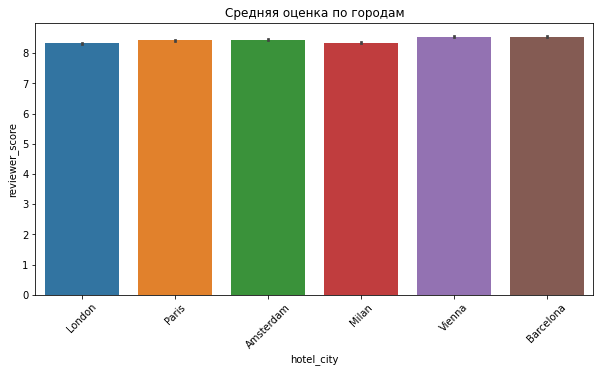

In [510]:
# Средняя оценка по городам
plt.rcParams['figure.figsize'] = (10,5)
barplot=sns.barplot(data=data[data['sample']==1], x='hotel_city', y='reviewer_score',)
barplot.xaxis.set_tick_params(rotation=45)
plt.title('Средняя оценка по городам')

Из столбчатых диаграм видно, что средние оценки по городам идентичны средним оценкам по странам, что говорит о мультиколлинеарности этих признаком, проверим это дальше, когда будем делать отбор признаков

### Год, квартал, месяц, день недели в котором был оставлен отзыв

In [511]:
# Преобразование признака review_date в формат data
data['review_date'] = pd.to_datetime(data['review_date'])

In [512]:
# Создание признака "год"
data['review_year'] = data['review_date'].dt.year
# Создание признака "квартал"
data['review_quarter'] = data['review_date'].dt.quarter
# Создание признака "месяц"
data['review_month'] = data['review_date'].dt.month
# Создание признака "день недели"
data['review_day_of_week'] = data['review_date'].dt.day_of_week

Text(0.5, 1.0, 'Средняя оценка по годам')

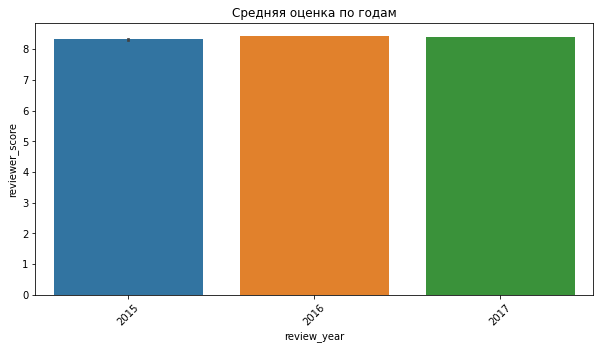

In [513]:
# Средняя оценка по годам
plt.rcParams['figure.figsize'] = (10,5)
barplot=sns.barplot(data=data[data['sample']==1], x='review_year', y='reviewer_score',)
barplot.xaxis.set_tick_params(rotation=45)
plt.title('Средняя оценка по годам')

Text(0.5, 1.0, 'Средняя оценкаи по квараталам')

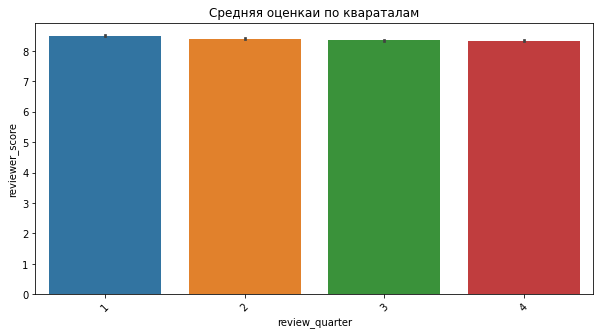

In [514]:
# Средняя оценка по кварталам
plt.rcParams['figure.figsize'] = (10,5)
barplot=sns.barplot(data=data[data['sample']==1], x='review_quarter', y='reviewer_score',)
barplot.xaxis.set_tick_params(rotation=45)
plt.title('Средняя оценкаи по квараталам')

Text(0.5, 1.0, 'Средняя оценка по месяцам')

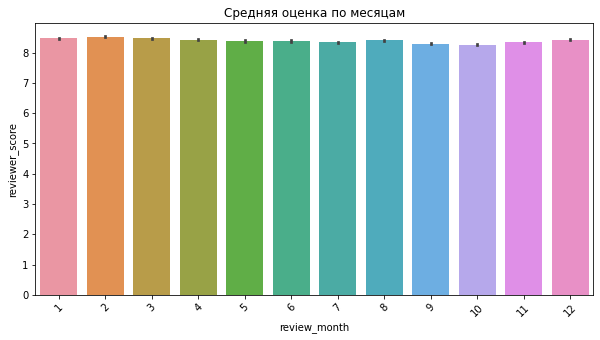

In [515]:
# Средняя оценка по месяцам
plt.rcParams['figure.figsize'] = (10,5)
barplot=sns.barplot(data=data[data['sample']==1], x='review_month', y='reviewer_score',)
barplot.xaxis.set_tick_params(rotation=45)
plt.title('Средняя оценка по месяцам')

Text(0.5, 1.0, 'Средняя оценка по дням недели')

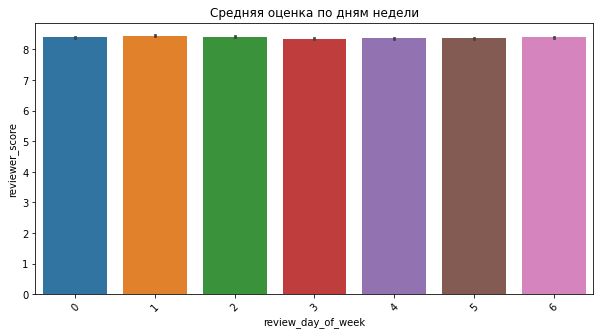

In [516]:
# Средняя оценка по дням недели
plt.rcParams['figure.figsize'] = (10,5)
barplot=sns.barplot(data=data[data['sample']==1], x='review_day_of_week', y='reviewer_score',)
barplot.xaxis.set_tick_params(rotation=45)
plt.title('Средняя оценка по дням недели')

Из столбчатых диаграм видно, что средние оценки по времени (квартал, месяц) идентичны , что говорит о мультиколлинеарности этих признаком, проверим это дальше, когда будем делать отбор признаков

### Количсетво ночей, проведенных в отеле

In [517]:
# Преобразуем признак "тэги" в надлежащий вид - список с тэгами
data['tags'] = data['tags'].apply(lambda x: x.replace("[' ", '').replace(" ']", '').split(" ', ' "))

In [518]:
# Инициализируем словарь с тэгами и их количеством для понимания, какие тэги есть и что с ними можно сделать
tag_dict = {}
for row in data['tags']:
    for tag in row:
        if tag not in tag_dict:
            tag_dict[tag] = 1
        else:
            tag_dict[tag] += 1
len(tag_dict)

data_tags = pd.DataFrame.from_dict({'tag': tag_dict.keys(), 'count': tag_dict.values()})

# Выделим 20 популярных тэгов
data_tags.sort_values(by='count', ascending=False)[:20]

,tag,count
0,Leisure trip,417538
4,Submitted from a mobile device,307470
1,Couple,252128
7,Stayed 1 night,193568
3,Stayed 2 nights,133850
8,Solo traveler,108476
10,Stayed 3 nights,95761
5,Business trip,82884
25,Group,65361
20,Family with young children,60989


In [519]:
# Создадим цикл для определение колчиества ночей, на которые оставались рецензенты
for tag in data_tags['tag']:
    if 'Stayed' in tag:
        print(tag)

Stayed 2 nights
Stayed 1 night
Stayed 3 nights
Stayed 6 nights
Stayed 4 nights
Stayed 5 nights
Stayed 8 nights
Stayed 7 nights
Stayed 10 nights
Stayed 14 nights
Stayed 19 nights
Stayed 13 nights
Stayed 9 nights
Stayed 17 nights
Stayed 11 nights
Stayed 27 nights
Stayed 12 nights
Stayed 15 nights
Stayed 21 nights
Stayed 18 nights
Stayed 16 nights
Stayed 26 nights
Stayed 24 nights
Stayed 30 nights
Stayed 22 nights
Stayed 23 nights
Stayed 28 nights
Stayed 20 nights
Stayed 25 nights
Stayed 29 nights
Stayed 31 nights


In [520]:
# Функция для определения количества ночей, проведенных рецензентами
def get_night_stayed(lst):
    """Функция получает на вход список тэгов и возвращает количество ночей, проведенных в отеле.

    Args:
        lst: Входные данные в формате списка

    Returns:
        int: Возвращает данные в формате числа
    """
    count= 0
    for tag in lst:
        tag = tag.split(' ')
        for word in tag:
            if 'Stayed' in word:
                count = int(tag[tag.index(word) + 1])
                return count
    return count

# Cоздадим признак "количество ночей в отеле"
data['night_stayed'] = data['tags'].apply(get_night_stayed)

Text(0.5, 1.0, 'Средняя оценка по количеству ночей')

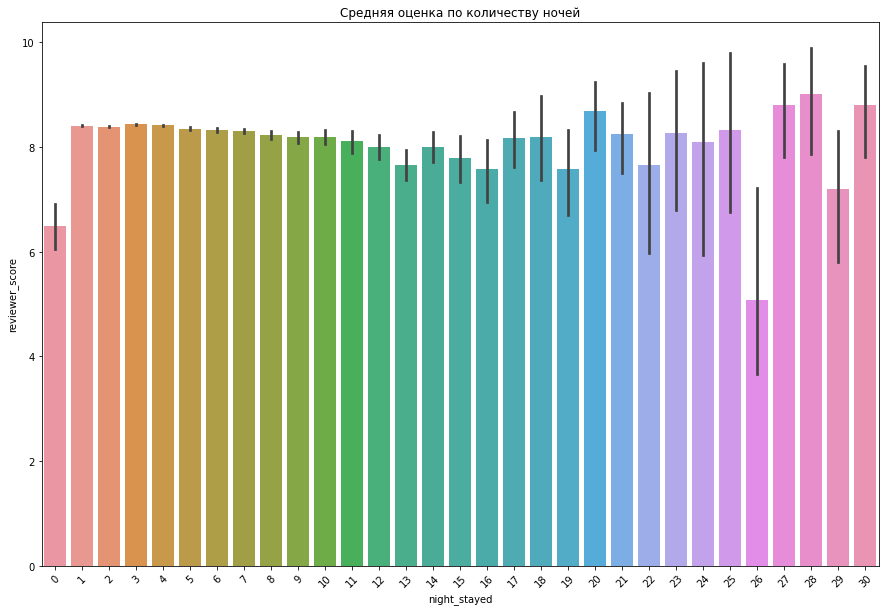

In [521]:
# Средняя оценка по количеству ночей
plt.rcParams['figure.figsize'] = (15,10)
barplot=sns.barplot(data=data[data['sample']==1], x='night_stayed', y='reviewer_score',)
barplot.xaxis.set_tick_params(rotation=45)
plt.title('Средняя оценка по количеству ночей')

### Количество тэгов

In [522]:
# Функция подсчета количества тегов

def get_tag_cnt(row):
    return len(row)

In [523]:
data['tag_cnt'] = data['tags'].apply(get_tag_cnt)

### Цель поездки

In [524]:
for tag in data_tags['tag']:
    if 'trip' in tag:
        print(tag)

Leisure trip
Business trip


Иммется всего две цели: туристическая и бизнес, но также ещё есть поездки без указания цели (назовем ее unknown

In [525]:
# Функция для определения туристической поездки
def get_leisure_trip(lst):
    """Функция получает на вход список тэгов и возвращает является ли поездка туристической.

    Args:
        lst: Входные данные в формате списка

    Returns:
        int: Возвращает данные в формате числа
    """
    if 'Leisure trip' in lst:
        return 1
    else:
        return 0

# Функция для определения рабочей поездки
def get_business_trip(lst):
    """Функция получает на вход список тэгов и возвращает является ли поездка рабочей.

    Args:
        lst: Входные данные в формате списка

    Returns:
        int: Возвращает данные в формате числа
    """
    if 'Business trip' in lst:
        return 1
    else:
        return 0

# Функция для определения поездки без указания цели
def get_unknown_trip(lst):
    """Функция получает на вход список тэгов и возвращает является ли поездка без указания цели.

    Args:
        lst: Входные данные в формате списка

    Returns:
        int: Возвращает данные в формате числа
    """
    if 'Business trip' not in lst and 'Leisure trip' not in lst:
        return 1
    else:
        return 0
    
# Применение функций к датасету
data['leisure_trip'] = data['tags'].apply(get_leisure_trip)
data['business_trip'] = data['tags'].apply(get_business_trip)
data['unknown_trip'] = data['tags'].apply(get_unknown_trip)

### Колчество человек в поездке

In [526]:
# Функция определения одного человека в поездке
def get_solo_trip(row):
    if 'Solo traveler' in row:
        return 1
    else:
        return 0

# Функция определения двух человек в поездке
    
def get_couple_trip(row):
    if 'Couple' in row:
        return 1
    else:
        return 0

# Функция определения группы людей в поездке
    
def get_group_trip(row):
    if 'Group' in row:
        return 1
    else:
        return 0

In [527]:
# Создадим признаки

data['solo_trip'] = data['tags'].apply(get_solo_trip)
data['couple_trip'] = data['tags'].apply(get_couple_trip)
data['group_trip'] = data['tags'].apply(get_group_trip)

### Позитивные и негативные отзывы

С помощью бибилиотеки NLTK можно дать тональную оценку отзыва

In [528]:
nltk.download('vader_lexicon')

# Создание экземпляра SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Функция для анализа тональности текста
def analyze_sentiment(text):
    return sent_analyzer.polarity_scores(text)['compound']

# Применение функции к признакам "negative_review" и "positive_review"
data['negative_review_sentiment'] = data['negative_review'].apply(analyze_sentiment)
data['positive_review_sentiment'] = data['positive_review'].apply(analyze_sentiment)

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


### Рецензент является ли гражданином страны

In [529]:
# Создание признака показывающего, является ли рецензент гражданином страны отеля

data['reviewier_is_resident'] = data['hotel_country'].str.strip() == data['reviewer_nationality'].str.strip()
data['reviewier_is_resident'] = data['reviewier_is_resident'].astype('int')

In [530]:
# Посмотрим на процентное соотношение рецензентов, являющихся гражданинами страны и не являющихся

data['reviewier_is_resident'].value_counts(normalize=True)*100

0    65.391294
1    34.608706
Name: reviewier_is_resident, dtype: float64

Text(0.5, 1.0, 'Рецензент - резидент?')

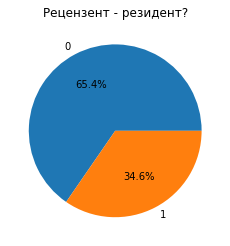

In [531]:
# Соотношение рецензентов резидентов страны и рецензентов не резидентов страны

reviewier_is_resident_plt = data['reviewier_is_resident'].value_counts()
fig = plt.figure(figsize=(3, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    reviewier_is_resident_plt,
    labels=reviewier_is_resident_plt.index,
    autopct='%.1f%%'
);
plt.title('Рецензент - резидент?')

### Преобразование признака days_since_review

In [532]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

In [533]:
data['days_since_review'].nunique()

731

In [534]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

## 4. Кодирование признаков

In [535]:
# Импорт библиотеки для кодирования категориальных признаков
import category_encoders as ce

### Кодирование признака количество ночей в поездке

In [536]:
# Количество уникальных значений
data['night_stayed'].nunique()

32

In [537]:
# Количество значений велико, поэтому используем бинарное кодирование
bin_encoder = ce.BinaryEncoder(cols=['night_stayed'])
nationality_bin = bin_encoder.fit_transform(data['night_stayed'])
data = pd.concat([data, nationality_bin], axis=1)

### Кодирование признака 'reviwer_nationality'

In [538]:
# Количество уникальных значений
data['reviewer_nationality'].nunique()

227

In [539]:
# Количество значений велико, поэтому используем бинарное кодирование
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
nationality_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, nationality_bin], axis=1)

### Кодирование признака hotel_country

In [540]:
# Количество уникальных значений
data['hotel_country'].nunique()

6

In [541]:
# Количество значений мало, поэтому используем OneHotEncoder
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True)
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)

### Кодирование признака hotel_city

In [542]:
# Количество уникальных значений
data['hotel_city'].nunique()

6

In [543]:
# Количество значений мало, поэтому используем OneHotEncoder
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True)
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

## 5. Нормализация числовых признаков

In [544]:
# Импорт библиотеки для нормализации
from sklearn import preprocessing

### Нормализация признака additional_number_of_scoring

In [545]:
data['additional_number_of_scoring'] = preprocessing.RobustScaler().fit_transform(np.array(data['additional_number_of_scoring']).reshape(-1,1))

## 6. Отбор признаков

In [546]:
# Удалим ненужные признаки, которые преобразовали в новые
data.drop(['hotel_address', 'review_date', 'hotel_name','hotel_country',
           'hotel_city', 'reviewer_nationality', 'tags', 'lat', 'lng', 
           'negative_review', 'positive_review', 'night_stayed'], axis=1 , inplace=True)

In [547]:
data.nunique(dropna=False)

additional_number_of_scoring                    480
average_score                                    34
review_total_negative_word_counts               402
total_number_of_reviews                        1142
review_total_positive_word_counts               365
total_number_of_reviews_reviewer_has_given      198
reviewer_score                                   38
days_since_review                               731
sample                                            2
review_year                                       3
review_quarter                                    4
review_month                                     12
review_day_of_week                                7
tag_cnt                                           6
leisure_trip                                      2
business_trip                                     2
unknown_trip                                      2
solo_trip                                         2
couple_trip                                       2
group_trip  

### Проводим корреляционный анализ для непрерывных признаков

In [548]:
# Непрерывные признаки

num_cols = [
    'additional_number_of_scoring', 'average_score', 'total_number_of_reviews', 
    'review_total_negative_word_counts', 'review_total_positive_word_counts', 
    'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'tag_cnt', 
    'negative_review_sentiment', 'positive_review_sentiment'
]

In [549]:
# Функция построения матрицы корреляции

def show_corr_heatmap(columns_list, title, method):
    """Функция получает на вход список колонок датафрейма (признаков), название матрицы 
    корреляции, метод корреляционного анализа и возвращает тепловую карту корреляции.

    Args:
        lst: Входные данные в формате списка
        str: Входные данные в формате списка
        str: Входные данные в формате списка

    Returns:
        graph: Возвращает данные в формате графика
    """
    fig_, ax_ = plt.subplots(figsize=(20, 15))
    corr = data[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr,
                annot=True,
                linewidths=0.1,
                ax=ax_,
                mask=mask,
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

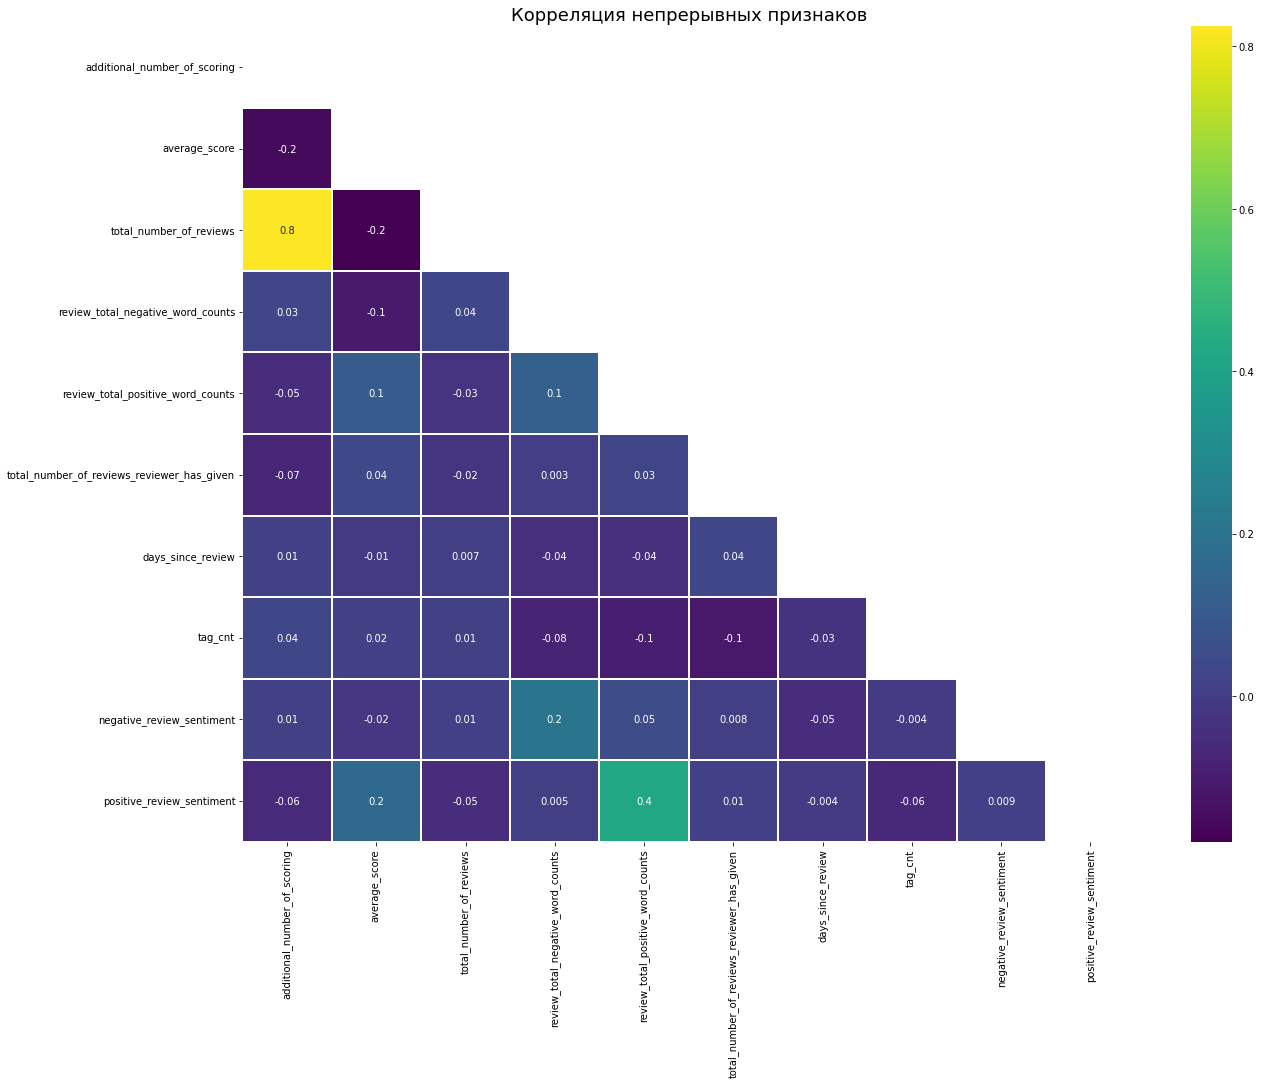

In [550]:
# Матрица корреляии непрерывных признаков
show_corr_heatmap(num_cols, 'Корреляция непрерывных признаков', method='pearson')

### Проводим корреляционный анализ для категориальных признаков

In [551]:
# Категориальные признаки

cat_cols = [
    'review_year', 'review_quarter', 'review_month', 'review_day_of_week', 
    'hotel_country_United Kingdom' , 
    'hotel_country_France', 'hotel_country_Netherlands', 'hotel_country_Italy', 
    'hotel_country_Austria', 'hotel_country_Spain', 'reviewier_is_resident',
    'hotel_city_Milan' , 'hotel_city_Amsterdam', 'hotel_city_Barcelona', 
    'hotel_city_London', 'hotel_city_Paris', 'hotel_city_Vienna',
    'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2',
    'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5', 
    'reviewer_nationality_6','reviewer_nationality_7', 'leisure_trip', 'business_trip', 
    'unknown_trip', 'night_stayed_0', 'night_stayed_1', 'night_stayed_2', 'night_stayed_3', 
    'night_stayed_4', 'night_stayed_5', 'solo_trip', 'couple_trip', 'group_trip' 
]

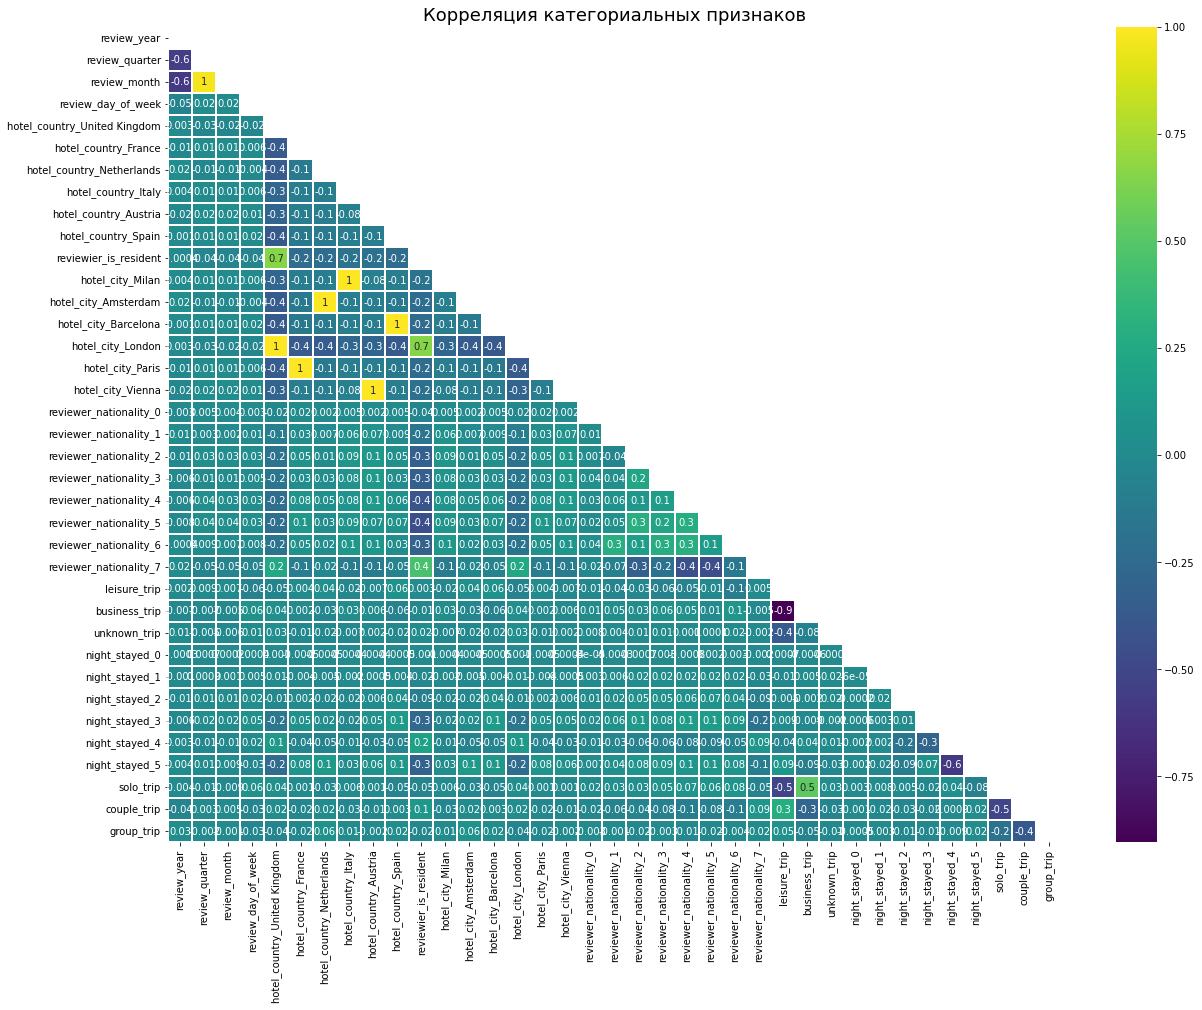

In [552]:
# Матрица корреляии категориальных признаков
show_corr_heatmap(cat_cols, 'Корреляция категориальных признаков', method='spearman')

In [553]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 49 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  float64
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   days_since_review                           515431 non-null  int64  
 8   sample                                      515431 non-null  int64  
 9   review_year                                 515431 non-null  int64  
 

### Оценка значимости признаков
#### Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

In [554]:
# Импорт библиотек для тестов chi2 и ANOVA
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

#### Оценка значимости категориальных признаков

<AxesSubplot:>

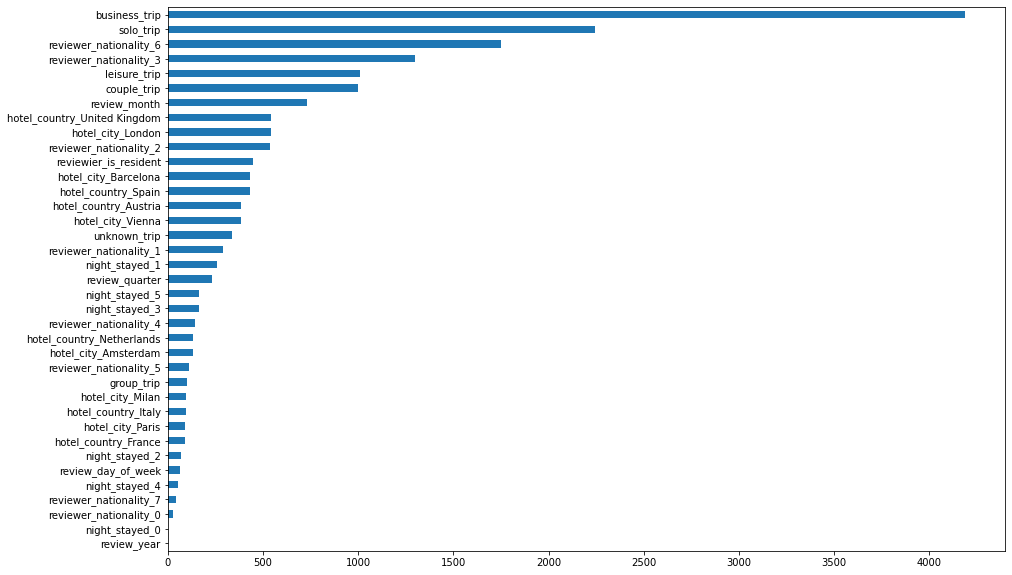

In [555]:
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score']  
y = y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [556]:
imp_cat

review_year                        0.055663
night_stayed_0                     2.997603
reviewer_nationality_0            27.431812
reviewer_nationality_7            42.201856
night_stayed_4                    56.001561
review_day_of_week                64.327931
night_stayed_2                    70.140239
hotel_country_France              90.184133
hotel_city_Paris                  90.184133
hotel_country_Italy               95.029757
hotel_city_Milan                  95.029757
group_trip                        98.100501
reviewer_nationality_5           110.486374
hotel_city_Amsterdam             131.532280
hotel_country_Netherlands        131.532280
reviewer_nationality_4           145.024348
night_stayed_3                   162.339332
night_stayed_5                   162.373351
review_quarter                   230.419570
night_stayed_1                   258.005397
reviewer_nationality_1           291.658668
unknown_trip                     335.441490
hotel_city_Vienna               

#### Оценка значимости числовых признаков

<AxesSubplot:>

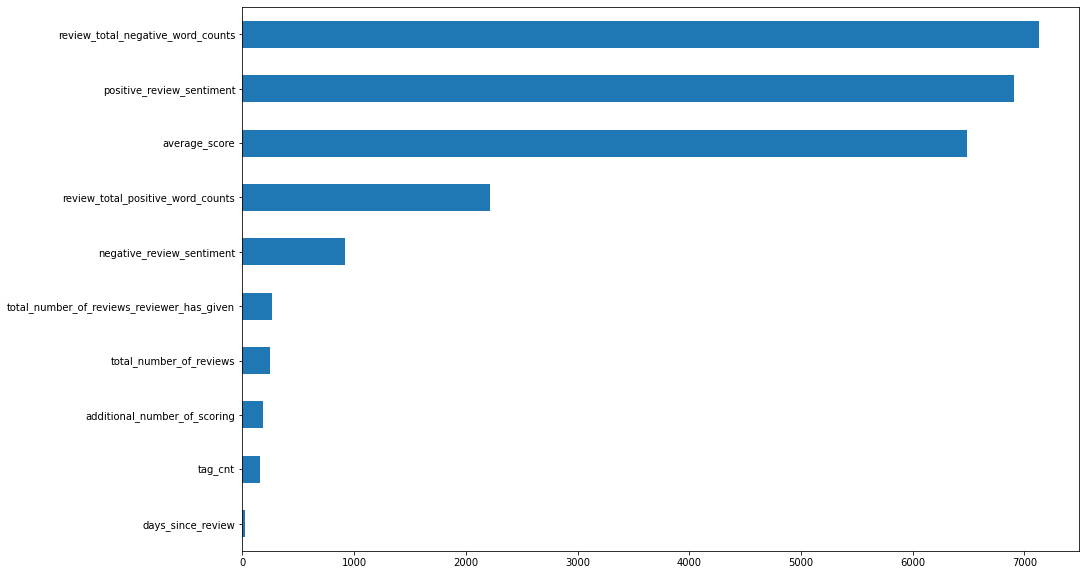

In [557]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [558]:
imp_num

days_since_review                               23.776698
tag_cnt                                        160.843268
additional_number_of_scoring                   188.228564
total_number_of_reviews                        246.510528
total_number_of_reviews_reviewer_has_given     266.916510
negative_review_sentiment                      920.282380
review_total_positive_word_counts             2220.730740
average_score                                 6485.969037
positive_review_sentiment                     6904.226400
review_total_negative_word_counts             7134.562667
dtype: float64

#### Очистка датасета от малозначимых признаков признаков имеющих высокую корреляцию

In [559]:
data.drop(['review_year', 'review_month', 'business_trip', 'night_stayed_0', 'hotel_city_Milan', 'hotel_city_Amsterdam', 'hotel_city_Barcelona', 
    'hotel_city_London', 'hotel_city_Paris', 'hotel_city_Vienna'], axis = 1, inplace=True)

In [560]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  float64
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   days_since_review                           515431 non-null  int64  
 8   sample                                      515431 non-null  int64  
 9   review_quarter                              515431 non-null  int64  
 

## 7. Обучение модели и получение предсказания¶

In [561]:
# Теперь выделим тестовую часть

train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [562]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [563]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 38), (386496, 38), (386496, 37), (309196, 37), (77300, 37))

In [564]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [565]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [566]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [567]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred)*100)

MAPE: 87.73064277705906


<AxesSubplot:>

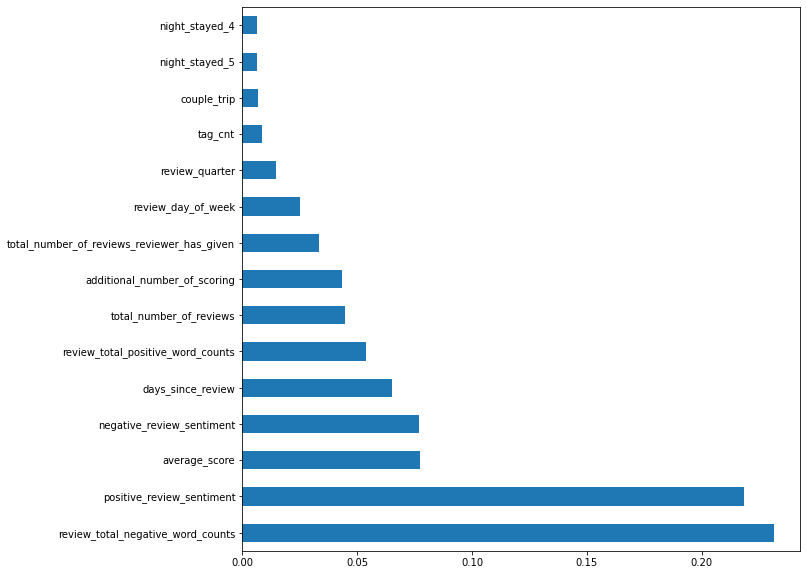

In [568]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [569]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,review_quarter,review_day_of_week,...,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain
438651,-0.232179,8.5,3,2279,5,15,0.0,443,2,1,...,1,1,1,1,0,0,0,0,1,0
486532,-0.130346,8.4,13,1971,0,1,0.0,11,3,6,...,1,0,0,0,0,0,1,0,0,0
484114,-0.368635,8.9,8,1369,14,3,0.0,494,1,6,...,1,0,1,0,0,0,1,0,0,0
500389,-0.234216,8.0,3,1069,6,7,0.0,239,4,2,...,0,0,0,1,1,0,0,0,0,0
437853,-0.075356,8.0,67,3565,17,2,0.0,114,2,1,...,0,1,1,1,0,0,0,0,0,1
468749,-0.142566,8.4,14,3224,3,50,0.0,721,3,3,...,0,0,1,1,0,0,0,0,1,0
471856,-0.128310,8.8,11,3598,9,3,0.0,398,3,4,...,0,1,0,0,0,0,0,0,1,0
448159,-0.203666,9.1,3,944,23,32,0.0,100,2,1,...,1,1,1,0,1,0,0,0,0,0
507104,-0.464358,8.7,25,602,0,4,0.0,426,2,4,...,0,0,0,1,1,0,0,0,0,0
405044,-0.097760,8.7,12,1271,5,1,0.0,263,4,6,...,0,0,0,1,1,0,0,0,0,0


In [570]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [571]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [572]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [573]:
predict_submission

array([8.608, 7.495, 8.519, ..., 8.067, 9.581, 7.291])

In [574]:
list(sample_submission)

['reviewer_score', 'id']

In [575]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.608,488440
1,7.495,274649
2,8.519,374688
3,9.674,404352
4,9.493,451596
5,8.864,302161
6,8.090,317079
7,7.521,13963
8,8.555,159785
9,7.454,195089
